# Recession Prediction Machine Learning Modeling with Economic Indicators

## Setup and Imports
This section initializes the foundation of our analysis by importing essential libraries for data manipulation, 
machine learning, and visualization, ensuring all necessary tools are available for recession prediction.


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
import pandas_datareader as web
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Define date range
start_date = datetime(1990, 1, 1)
end_date = datetime(2025, 4, 1)  # Current date

## Fetch Recession Labels
Here, we define a function to generate binary recession labels based on historical NBER data, providing the target variable for our predictive modeling efforts.

In [4]:
def fetch_recession_labels(start_date, end_date):
    """
    Creates binary recession labels based on NBER recession dates
    """
    # NBER recession periods (manually defined based on historical data up to 2023)
    recession_periods = [
        ('1990-07-01', '1991-03-31'),
        ('2001-03-01', '2001-11-30'),
        ('2007-12-01', '2009-06-30'),
        ('2020-02-01', '2020-04-30')
    ]
    
    print(f"Creating recession labels based on {len(recession_periods)} historical recession periods")
    
    dates = pd.date_range(start=start_date, end=end_date, freq='ME')
    labels = pd.Series(0, index=dates)
    
    for start, end in recession_periods:
        labels.loc[start:end] = 1
    
    return labels

## Data Exploration and Visualization
This section dives into the initial exploration of economic indicators, offering visual insights into trends and relationships while highlighting recession periods for context.

In [5]:
# Fetch data and set 'DATE' as index
economic_indicators = pd.read_csv('./data/economic_indicators.csv', 
                                  index_col='DATE', 
                                  parse_dates=True)

# Display basic information
print("\nDataset shape:", economic_indicators.shape)
print("\nFirst 5 rows:")
print(economic_indicators.head())


Dataset shape: (9318, 13)

First 5 rows:
            unemployment  yield_spread  industrial_prod  consumer_conf  SP500  \
DATE                                                                            
1990-01-01           5.4           NaN          61.6352           93.0    NaN   
1990-01-02           5.4          0.07          61.6352           93.0    NaN   
1990-01-03           5.4          0.05          61.6352           93.0    NaN   
1990-01-04           5.4          0.06          61.6352           93.0    NaN   
1990-01-05           5.4          0.09          61.6352           93.0    NaN   

             LEI    CPI    GDP_Growth  recession_probabilities  \
DATE                                                             
1990-01-01  1.71  127.5  10047.386000                      0.2   
1990-01-02  1.71  127.5  10047.947062                      0.2   
1990-01-03  1.71  127.5  10048.508123                      0.2   
1990-01-04  1.71  127.5  10049.069185                      0

In [6]:
# Fetch recession labels
recession_labels = fetch_recession_labels(start_date, 
                                          end_date)
recession_labels = recession_labels.reindex(economic_indicators.index, 
                                            method='ffill')

Creating recession labels based on 4 historical recession periods


In [7]:
# Create a DataFrame with both data and labels for visualization
economic_indicators_with_labels = economic_indicators.copy()
economic_indicators_with_labels['Recession'] = recession_labels

In [97]:
# Calculate required rows based on number of indicators
num_indicators = len(economic_indicators.columns)
rows = int(np.ceil(num_indicators / 2))  # 2 columns, adjust rows dynamically

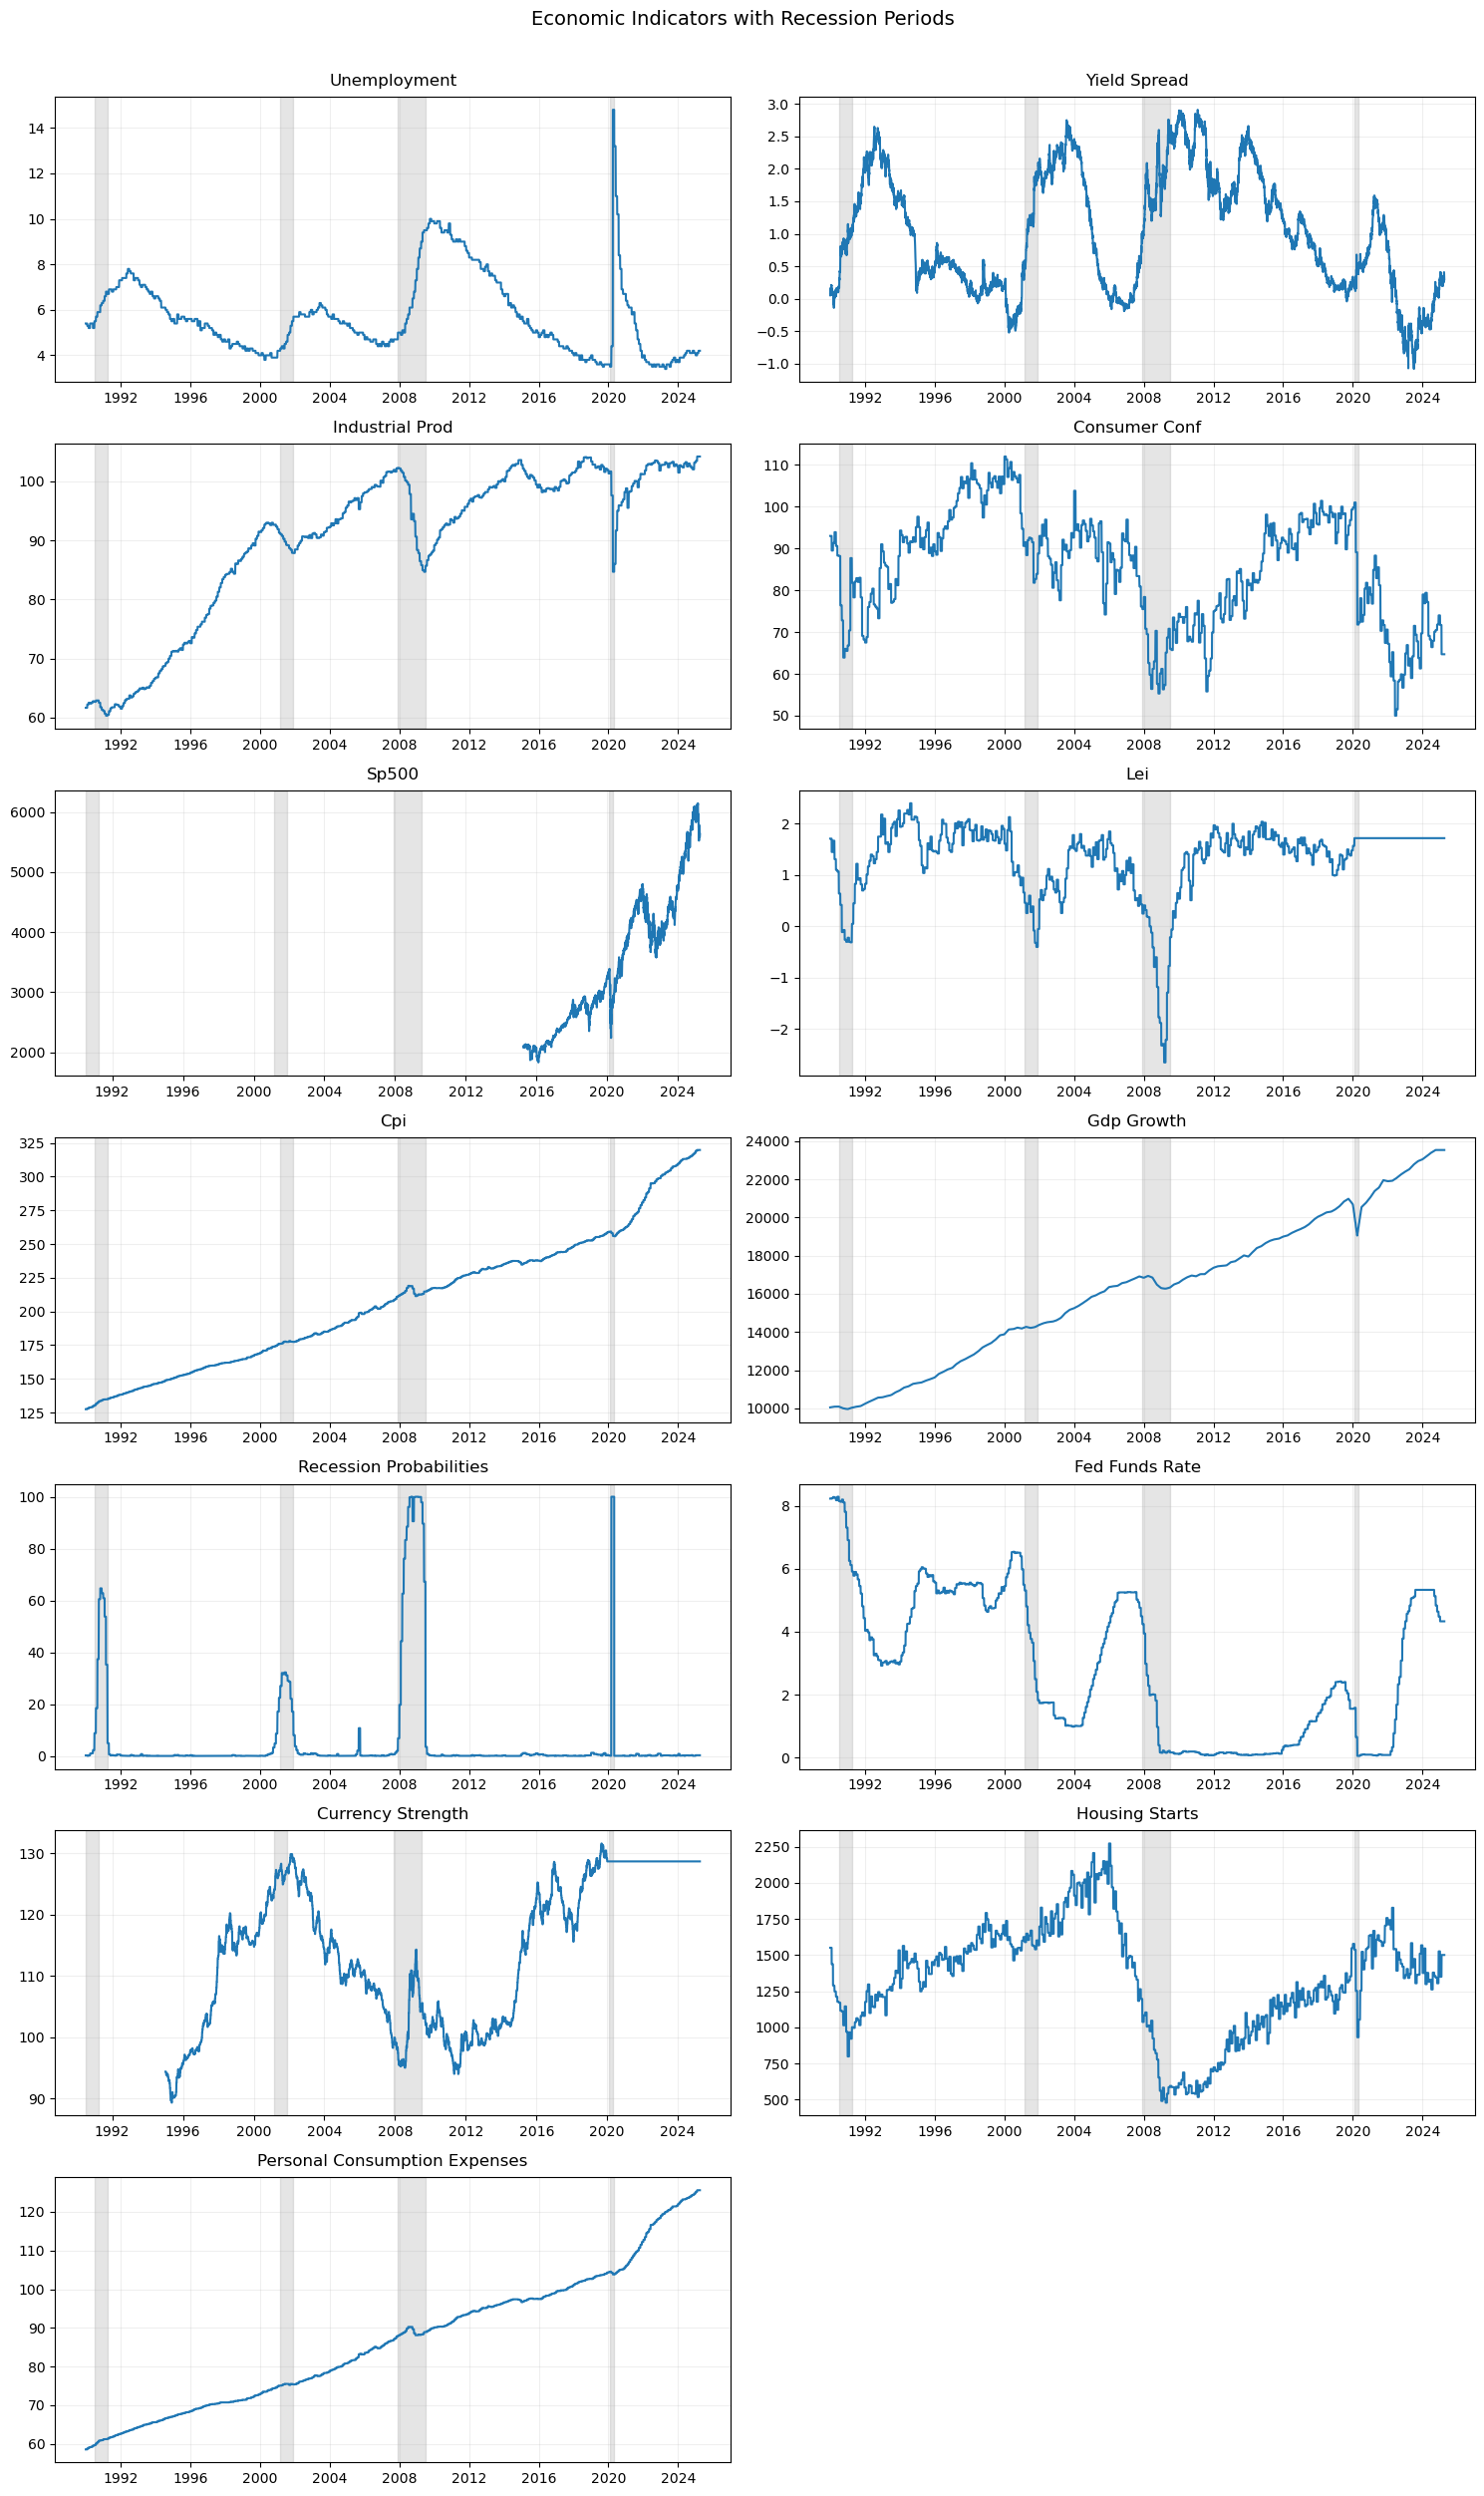

In [100]:
# Plot economic indicators
plt.figure(figsize=(15, 3.5 * rows))  # Dynamic height based on rows

for i, column in enumerate(economic_indicators.columns):
    plt.subplot(rows, 2, i+1)  # 2 columns, dynamic rows
    plt.plot(economic_indicators.index, economic_indicators[column], lw=1.5)
    
    # Highlight recession periods
    for start, end in [('1990-07-01', '1991-03-31'), 
                       ('2001-03-01', '2001-11-30'),
                       ('2007-12-01', '2009-06-30'),
                       ('2020-02-01', '2020-04-30')]:
        plt.axvspan(start, end, color='gray', alpha=0.2)
    
    plt.title(column.replace('_', ' ').title(), pad=8)
    plt.grid(alpha=0.2)

plt.tight_layout()
plt.suptitle("Economic Indicators with Recession Periods", y=1.02, fontsize=14)
plt.show();

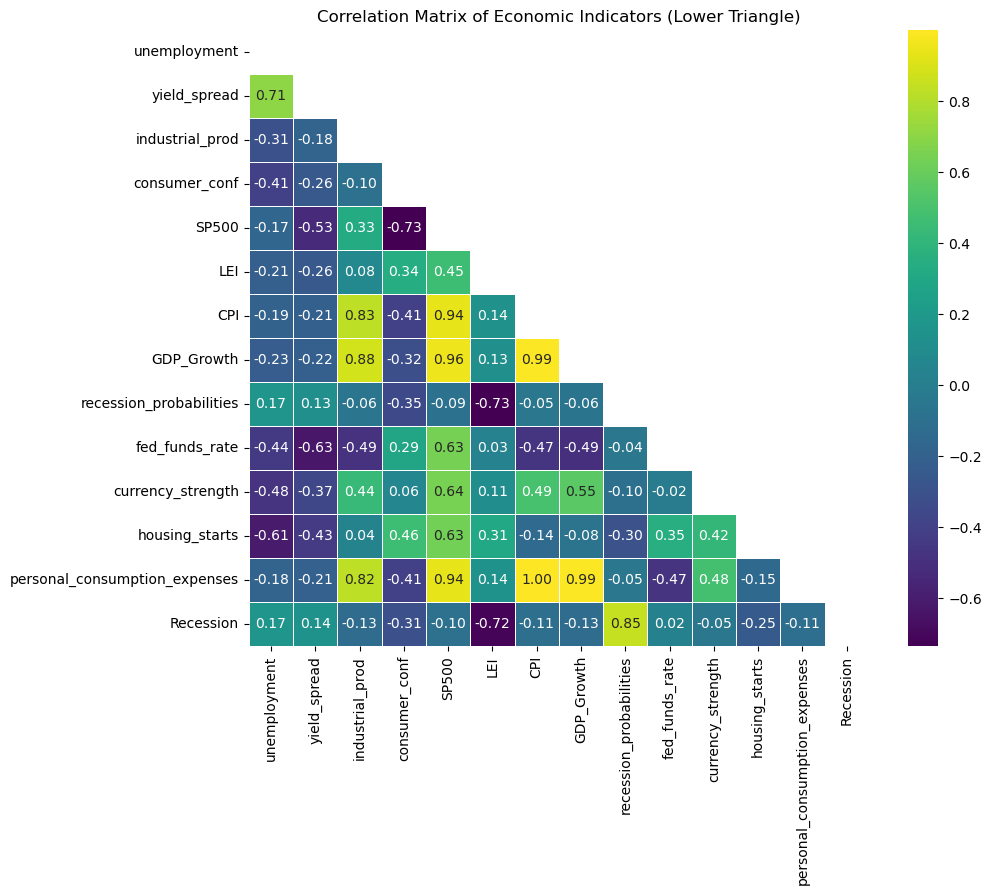

In [102]:
# Calculate correlation matrix and show only lower triangle with colorblind-friendly palette
plt.figure(figsize=(10, 8))
correlation = economic_indicators_with_labels.corr()
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation, dtype=bool))
# Use a colorblind-friendly colormap (viridis)
sns.heatmap(correlation, annot=True, cmap='viridis', fmt=".2f", linewidths=0.5, mask=mask)
plt.title('Correlation Matrix of Economic Indicators (Lower Triangle)')
plt.show()

## Exploratory Data Analysis
In this section, we conduct a deeper statistical analysis of the economic indicators, examining distributions, summary statistics, and missing data to inform our modeling approach.

In [103]:
# Summary statistics
print("\nSummary Statistics of Economic Indicators:")
print(economic_indicators.describe())


Summary Statistics of Economic Indicators:
       unemployment  yield_spread  industrial_prod  consumer_conf  \
count   9318.000000   9317.000000      9318.000000    9318.000000   
mean       5.702318      1.018613        90.229926      85.084889   
std        1.743871      0.922728        13.076332      13.373528   
min        3.400000     -1.080000        60.297300      50.000000   
25%        4.400000      0.230000        85.186700      74.400000   
50%        5.400000      0.940000        93.968400      87.700000   
75%        6.600000      1.800000       100.374000      95.000000   
max       14.800000      2.910000       104.206200     112.000000   

             SP500          LEI          CPI    GDP_Growth  \
count  2640.000000  9318.000000  9318.000000   9318.000000   
mean   3454.258557     1.318691   207.872900  16255.480103   
std    1135.105184     0.731288    49.541579   3820.914803   
min    1829.080000    -2.650000   127.500000   9951.916000   
25%    2488.785000     1

In [105]:
# Check for missing values
print("\nMissing Values in Each Column:")
print(economic_indicators.isnull().sum())


Missing Values in Each Column:
unemployment                        0
yield_spread                        1
industrial_prod                     0
consumer_conf                       0
SP500                            6678
LEI                                 0
CPI                                 0
GDP_Growth                          0
recession_probabilities             0
fed_funds_rate                      0
currency_strength                1324
housing_starts                      0
personal_consumption_expenses       0
dtype: int64


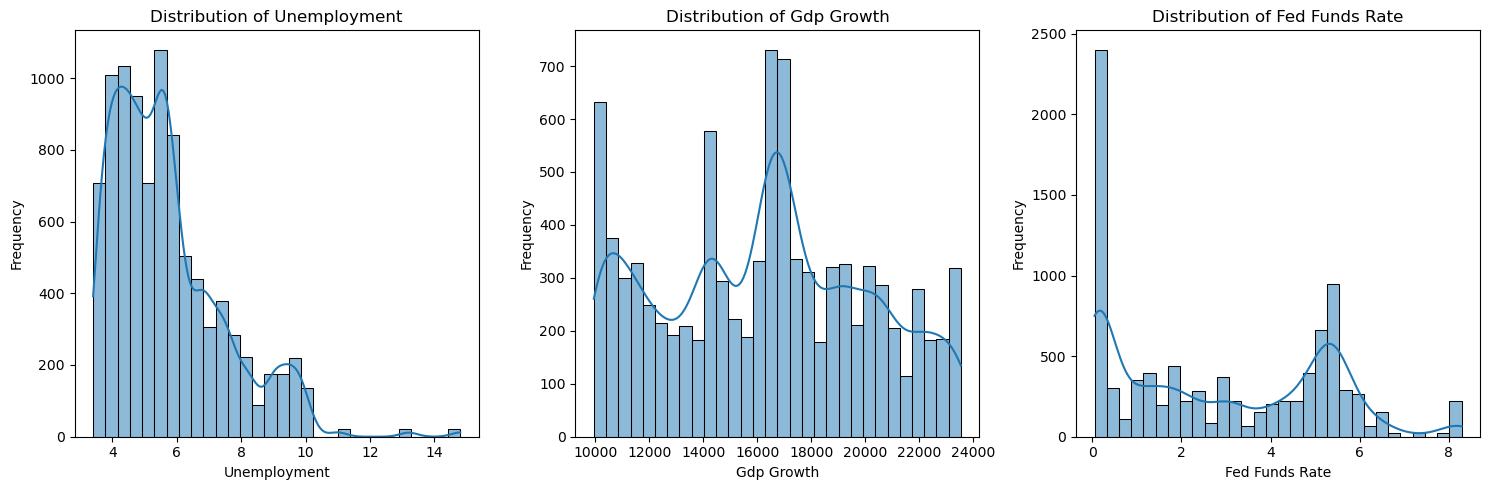

In [109]:
# Plot distribution of key indicators
key_indicators = ['unemployment', 'GDP_Growth', 'fed_funds_rate']
plt.figure(figsize=(15, 5))
for i, indicator in enumerate(key_indicators, 1):
    plt.subplot(1, 3, i)
    sns.histplot(economic_indicators[indicator].dropna(), bins=30, kde=True, color='tab:blue')
    plt.title(f'Distribution of {indicator.replace("_", " ").title()}')
    plt.xlabel(indicator.replace('_', ' ').title())
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [110]:
economic_indicators_with_labels.dtypes

unemployment                     float64
yield_spread                     float64
industrial_prod                  float64
consumer_conf                    float64
SP500                            float64
LEI                              float64
CPI                              float64
GDP_Growth                       float64
recession_probabilities          float64
fed_funds_rate                   float64
currency_strength                float64
housing_starts                   float64
personal_consumption_expenses    float64
Recession                        float64
dtype: object

## Data Preparation
This section prepares the data for machine learning by cleaning, scaling, and structuring it appropriately for recession prediction modeling.